In [52]:
import pandas as pd
import json
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, classification_report
from imblearn.over_sampling import SMOTE
import numpy as np
import joblib

data = {}

def load_json(file_path):
    with open(file_path, 'r', encoding="utf-8") as file:
        return json.load(file)


def preprocess_token_data(data: dict) -> pd.DataFrame:
    records = []
    for mint, token in data.items():
        for price_change in token.get("marketCapHistory", []):
            timestamp = price_change.get("timestamp")
            if timestamp > 10*10:
                timestamp = timestamp/1000
            records.append({
                "timestamp": timestamp,
                "marketCap": price_change.get("marketCap", 0),
                "symbol": token.get("symbol", "Unknown"),
                "volume": token.get("volume", 0),
                "numHolders": token.get("numHolders", 0),
                "sniperCount": token.get("sniperCount", 0),
                "progress": token.get("progress", 0),
                "buySellRatio": token.get("buySellRatio", 0),
                "liquidity": token.get("liquidity", 0),
                "volatility": token.get("volatility", 0)
            })

        for neo in token.get("Neo", []):
            records.append({
                "symbol": token.get("symbol", "Unknown"),
                "holderCounts": neo.get("holderCounts", 0),
                "tagsCount": neo.get("tagsCount", 0),
                "devHoldingSupplyPerc": neo.get("devHoldingSupplyPerc", 0),
                "insiderWalletsSupplyPerc": neo.get("insiderWalletsSupplyPerc", 0)
            })

        for trades in token.get("trades", []):
            records.append({
                "timestamp": trades.get("timestamp"),
                "symbol": token.get("symbol", "Unknown"),
                "solAmount": trades.get("solAmount", 0),
                "isBuy": trades.get("isBuy", 0),
            })

    return pd.DataFrame(records)


files = [
    'data/coiny_bez_limitu6.json',
    'data/coiny_bez_limitu7.json',
    'data/coiny_bez_limitu8.json',
    'data/coiny_bez_limitu9.json',
    'data/coiny_bez_limitu10.json',
    'data/coiny_bez_limitu11.json',
]

for file in files:
    data.update(load_json(file))

df = preprocess_token_data(data)
df

,timestamp,marketCap,symbol,volume,numHolders,sniperCount,progress,buySellRatio,liquidity,volatility,holderCounts,tagsCount,devHoldingSupplyPerc,insiderWalletsSupplyPerc,solAmount,isBuy
0,1.738860e+06,7887.522187,СОСКY,15.4587,21.0,10.0,24.06,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1.738860e+06,7892.808009,СОСКY,15.4587,21.0,10.0,24.06,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1.738860e+09,7885.040000,СОСКY,15.4587,21.0,10.0,24.06,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1.738860e+06,7935.138594,СОСКY,15.4587,21.0,10.0,24.06,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,1.738860e+06,7973.608513,СОСКY,15.4587,21.0,10.0,24.06,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409964,1.739034e+09,NaN,OFI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.500000e+09,True
409965,1.739034e+06,5432.958982,LCSE,0.0000,0.0,0.0,0.00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
409966,1.739034e+09,NaN,LCSE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.005390e+07,True
409967,1.739034e+06,5476.591540,ice,0.0000,0.0,0.0,0.00,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


# Sell Model - Detekce Příležitostí k Prodeji Meme Coinů

## Účel Notebooku
Tento notebook implementuje **model pro predikci prodejních signálů** u meme coinů pomocí XGBoost algoritmu. Model identifikuje okamžiky, kdy je vhodné prodat coin, aby se minimalizovaly ztráty nebo maximalizoval zisk.

## Přehled Procesu
1. **Načtení a předzpracování dat** - Import historických dat z JSON souborů
2. **Feature engineering** - Vytvoření technických indikátorů (RSI, EMA, volatilita, drawdown)
3. **Labelování dat** - Identifikace prodejních signálů na základě drawdown a RSI
4. **Balancování tříd** - Kombinace SMOTETomek pro trénovací data a downsampling pro testovací data
5. **Trénování modelu** - XGBoost s hyperparametry optimalizovanými přes Optuna
6. **Evaluace** - Metriky přesnosti, ROC křivka, confusion matrix, feature importance

## Rozdíl oproti Buy Modelu
Zatímco **Buy Model** hledá příležitosti k nákupu, **Sell Model** se zaměřuje na:
- Detekci **drawdown** (pokles z maxima)
- Vysoké hodnoty **RSI** (překoupení, hodnoty > 65)
- Identifikaci okamžiků, kdy je třeba prodat před dalším poklesem

## Klíčové Features
- `marketCap_change` - Procentuální změna tržní kapitalizace
- `marketCap_ema` - Exponenciální klouzavý průměr
- `rsi` - Relative Strength Index (vysoké hodnoty = signál k prodeji)
- `marketCap_change_ratio` - Poměr změny market capu
- `holders_growth` - Růst počtu držitelů
- `volatility_to_volume_ratio` - Poměr volatility k objemu

In [53]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df.sort_values(['symbol', 'timestamp'], inplace=True)

df['marketCap_change'] = df.groupby('symbol')['marketCap'].pct_change().fillna(0)
df['marketCap_ema'] = df.groupby('symbol')['marketCap'].transform(lambda x: x.ewm(span=7).mean())
df['rsi'] = df.groupby('symbol')['marketCap'].transform(lambda x:
    100 - (100 / (1 + x.pct_change().fillna(0).rolling(window=7).mean() / x.pct_change().fillna(0).rolling(window=7).std())))

df['marketCap_change_ratio'] = (df['marketCap'] - df['marketCap'].shift(1)) / df['marketCap'].shift(1)
df['holders_growth'] = df['numHolders'].diff().fillna(0)
df['volatility_to_volume_ratio'] = df['volatility'] / (df['volume'] + 1)

## Normalization
scaler = StandardScaler()
features_to_scale = ['marketCap', 'volume', 'numHolders', 'volatility']
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

df

,timestamp,marketCap,symbol,volume,numHolders,sniperCount,progress,buySellRatio,liquidity,volatility,...,devHoldingSupplyPerc,insiderWalletsSupplyPerc,solAmount,isBuy,marketCap_change,marketCap_ema,rsi,marketCap_change_ratio,holders_growth,volatility_to_volume_ratio
120353,1970-01-01 00:00:00.001738867,-0.684289,,-0.386521,-0.468673,2.0,8.19,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.000000,5922.552091,NaN,NaN,0.0,0.0
120354,1970-01-01 00:00:00.001738867,-0.684289,,-0.386521,-0.468673,2.0,8.19,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.000000,5922.552091,NaN,0.000000,0.0,0.0
120356,1970-01-01 00:00:00.001738867,-0.696512,,-0.386521,-0.468673,2.0,8.19,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,-0.028486,5849.596030,NaN,-0.028486,0.0,0.0
120357,1970-01-01 00:00:00.001738867,-0.696512,,-0.386521,-0.468673,2.0,8.19,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.000000,5814.577120,NaN,0.000000,0.0,0.0
120358,1970-01-01 00:00:00.001738867,-0.696512,,-0.386521,-0.468673,2.0,8.19,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,0.000000,5794.668803,NaN,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124134,1970-01-01 00:00:01.738868202,NaN,🪦,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,20000000.0,True,0.000000,5560.532010,NaN,NaN,0.0,NaN
124135,1970-01-01 00:00:01.738868202,NaN,🪦,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,225143630.0,False,0.000000,5560.532010,NaN,NaN,0.0,NaN
124130,1970-01-01 00:00:01.738868203,-0.727690,🪦,-0.348167,-0.486215,7.0,0.09,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,-0.047634,5329.815208,-60.762522,NaN,0.0,0.0
123649,NaT,NaN,🪦,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.1095,0.0,NaN,NaN,0.000000,5329.815208,-60.762522,NaN,0.0,NaN


## Konverze Dat a Vytváření Nových Features

Stejně jako u Buy Modelu vytváříme technické indikátory:
- **marketCap_change**: Procentuální změna market capu
- **marketCap_ema**: Exponenciální klouzavý průměr (7-period)
- **rsi**: Relative Strength Index - pro Sell Model jsou důležité vysoké hodnoty (> 65)
- **marketCap_change_ratio**: Poměr změny market capu
- **holders_growth**: Růst počtu držitelů
- **volatility_to_volume_ratio**: Poměr volatility k objemu

Všechny features jsou normalizovány pomocí StandardScaler.

In [54]:
def label_sell_opportunity(group):
    window_size = 10
    sell_threshold = 5

    group['rolling_max'] = group['marketCap'].rolling(window=window_size, min_periods=1).max()
    drawdown = (group['rolling_max'] - group['marketCap']) / group['rolling_max'] * 100
    sell_label = (drawdown > sell_threshold).astype(int)

    group['sell_signal_confidence'] = ((group['rsi'] > 65) & (sell_label == 1)).astype(int)

    return group['sell_signal_confidence']


df['label'] = df.groupby('symbol', group_keys=False, observed=True).apply(label_sell_opportunity)
df.fillna(0, inplace=True)

features = ['marketCap_change', 'marketCap_ema', 'rsi', 'marketCap_change_ratio', 'holders_growth', 'volatility_to_volume_ratio']
X = df[features]
y = df['label']

X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.mean())

## Labelovací Funkce pro Prodejní Signály

### Jak Funguje
Funkce `label_sell_opportunity` používá dva klíčové indikátory:

1. **Rolling Drawdown**:
   - Sleduje pokles ceny z lokálního maxima v okně 10 období
   - Pokud drawdown překročí **5%**, indikuje potenciální prodejní signál

2. **RSI Filter**:
   - Kombinuje drawdown s RSI > 65 (překoupení)
   - **Label 1** přiřazen pouze když **drawdown > 5% A RSI > 65**
   - Tím filtrujeme false positives a identifikujeme jen skutečně rizikové okamžiky

### Logika
- **Label 1 (Prodejní signál)**: Když je coin překoupený (RSI > 65) a začíná klesat (drawdown > 5%)
- **Label 0**: Všechny ostatní situace

Tato strategie pomáhá identifikovat **top of the pump** - okamžik, kdy je vhodné prodat před poklesem.

In [55]:
df['label'].value_counts()

label
0    409848
1       121
Name: count, dtype: int64

## Zlepšení Distribuce Tříd v Trénovací a Testovací Sadě

V této sekci řešíme **extrémní nebalanci tříd** pomocí kombinace technik:

### Trénovací Sada - SMOTETomek
1. **SMOTETomek** aplikován na `X_train`:
   - **SMOTE**: Vytváří syntetické vzorky minority třídy (prodejní signály)
   - **Tomek Links**: Odstraňuje šumové vzorky z majoritní třídy
   - Výsledek: **Perfektně balancovaná trénovací sada** (50:50 ratio)

### Testovací Sada - Downsampling
2. **Downsampling** pro testovací sadu:
   - Snížíme počet vzorků třídy 0 na **20× více než třída 1**
   - Zachováváme realistický poměr, ale není tak extrémní jako v původních datech
   - Umožňuje lepší evaluaci modelu

### Proč Tato Strategie?
- Model se učí na balancovaných datech → lepší detekce prodejních signálů
- Testujeme na realističtějším poměru → vyhodnocení zobrazuje skutečnou použitelnost
- Prevence bias směrem k majoritní třídě (třída 0)

In [56]:
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from sklearn.utils import resample
import pandas as pd

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, stratify=y, random_state=42
)

smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

print("Training Set (After SMOTETomek):")
print(y_train_resampled.value_counts())

print("\nTest Set (Before Balancing):")
print(y_test.value_counts())

test_df = X_test.copy()
test_df['label'] = y_test

# Separate majority and minority classes
test_majority = test_df[test_df['label'] == 0]
test_minority = test_df[test_df['label'] == 1]

test_majority_downsampled = resample(
    test_majority,
    replace=False,
    n_samples=len(test_minority) * 20,
    random_state=42
)

balanced_test_df = pd.concat([test_majority_downsampled, test_minority])

X_test = balanced_test_df.drop(columns=['label'])
y_test = balanced_test_df['label']

# Checking distribution
print("\nTest Set (After Balancing):")
print(y_test.value_counts())


Training Set (After SMOTETomek):
label
0    245872
1    245872
Name: count, dtype: int64

Test Set (Before Balancing):
label
0    163940
1        48
Name: count, dtype: int64

Test Set (After Balancing):
label
0    960
1     48
Name: count, dtype: int64


In [57]:
import xgboost as xgb
import optuna
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, log_loss, f1_score
)


def objective(trial):
        params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'max_depth': trial.suggest_int('max_depth', 10, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.8, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 2, 8),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.5, 5),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 1500),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'max_delta_step': trial.suggest_int('max_delta_step', 2, 10),
        'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        'device': 'gpu'
        }

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        f1_scores = []

        X_np = X_train.to_numpy() if hasattr(X_train, "to_numpy") else X_train
        y_np = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train

        for train_idx, val_idx in skf.split(X_np, y_np):
            X_tr, X_val = X_np[train_idx], X_np[val_idx]
            y_tr, y_val = y_np[train_idx], y_np[val_idx]

            model = xgb.XGBClassifier(**params)
            model.fit(X_tr, y_tr)

            y_pred = model.predict(X_val)
            f1_scores.append(f1_score(y_val, y_pred, average='macro'))

        return np.mean(f1_scores)

optimized_params = {
    'max_depth': 6,
    'learning_rate': 0.025,
    'subsample': 0.85,
    'colsample_bytree': 0.85,
    'colsample_bylevel': 0.9,
    'reg_lambda': 1.5,
    'reg_alpha': 0.8,
    'n_estimators': 800,
    'min_child_weight': 1,
    'gamma': 0.1,
    'max_delta_step': 4,
    'grow_policy': 'depthwise',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'device': 'gpu',
    'early_stopping_rounds': 40
}


#Run Optimized Optuna Tuning
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=120)

# Get Best Hyperparameters
best_params = study.best_params
best_params['objective'] = 'binary:logistic'
best_params['eval_metric'] = 'logloss'
best_params['device'] = 'gpu'

print("Best Hyperparameters for 90%+ F1:", best_params)

#Train Final Model with Best Params
# **best_params uses params from hyperparametr tunning
final_model = xgb.XGBClassifier(**best_params)
eval_set = [(X_train, y_train), (X_test, y_test)]
final_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
)


# Make Predictions
y_pred_probs = final_model.predict_proba(X_test)[:, 1]
optimal_threshold = 0.5
y_pred = (y_pred_probs > optimal_threshold).astype(int)

print("Updated Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
logloss = log_loss(y_test, y_pred_probs)
print(f"Log Loss: {logloss}")

final_model.save_model("models/crypto_sell_model.json")

[I 2025-03-09 13:59:40,655] A new study created in memory with name: no-name-60d9b4ef-b736-4274-83be-4676144aad4b
[I 2025-03-09 13:59:51,788] Trial 0 finished with value: 0.8251541933003661 and parameters: {'max_depth': 15, 'learning_rate': 0.022359734055157274, 'subsample': 0.7997474471211821, 'colsample_bytree': 0.8751025764669702, 'colsample_bylevel': 0.9442923292497837, 'scale_pos_weight': 6.291493818888802, 'reg_lambda': 2.342010385348029, 'reg_alpha': 4.699941436279374, 'n_estimators': 1490, 'min_child_weight': 5, 'gamma': 0.2960736997751553, 'max_delta_step': 2, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.8251541933003661.
[I 2025-03-09 13:59:59,866] Trial 1 finished with value: 0.8588353848523813 and parameters: {'max_depth': 18, 'learning_rate': 0.03272501409265597, 'subsample': 0.9181812493977851, 'colsample_bytree': 0.8408372998727804, 'colsample_bylevel': 0.874142681345706, 'scale_pos_weight': 3.8109073517855214, 'reg_lambda': 2.1099159630542026, 'reg_alpha':

Best Hyperparameters for 90%+ F1: {'max_depth': 12, 'learning_rate': 0.02644320112982116, 'subsample': 0.9496006817327238, 'colsample_bytree': 0.829646468866766, 'colsample_bylevel': 0.8000822522943694, 'scale_pos_weight': 3.068331402241279, 'reg_lambda': 2.727430976856886, 'reg_alpha': 4.786267901078364, 'n_estimators': 1263, 'min_child_weight': 6, 'gamma': 0.058976314915236194, 'max_delta_step': 8, 'grow_policy': 'lossguide', 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'device': 'gpu'}
[0]	validation_0-logloss:0.12445	validation_1-logloss:0.22033
[1]	validation_0-logloss:0.12099	validation_1-logloss:0.21345
[2]	validation_0-logloss:0.11768	validation_1-logloss:0.21148
[3]	validation_0-logloss:0.11443	validation_1-logloss:0.20529
[4]	validation_0-logloss:0.11127	validation_1-logloss:0.19960
[5]	validation_0-logloss:0.10821	validation_1-logloss:0.19440
[6]	validation_0-logloss:0.10527	validation_1-logloss:0.19274
[7]	validation_0-logloss:0.10239	validation_1-logloss:0.188

## Hyperparametrová Optimalizace a Trénování Sell Modelu

### Optuna Optimalizace
Používáme **Optuna** framework pro hledání optimálních hyperparametrů:
- **120 trials** pro důkladné prohledání hyperparametrového prostoru
- **5-fold Stratified Cross-Validation**
- Optimalizace směrem k **F1 score** (vhodné pro nebalancovaná data)

### Upravené Hyperparametry pro Sell Model
Sell model používá konzervativnější nastavení:
- **max_depth=6**: Mělčí stromy (prevence overfittingu na vzácné prodejní signály)
- **learning_rate=0.025**: Nižší learning rate pro jemnější učení
- **n_estimators=800**: Méně stromů než u Buy Modelu
- **early_stopping_rounds=40**: Zastavení pokud se model nezlepšuje

### Trénování a Ukládání
Po optimalizaci:
1. Trénujeme finální model s nejlepšími hyperparametry
2. Používáme GPU pro rychlejší výpočet
3. Ukládáme model jako `crypto_sell_model.json`

Model je teď připraven k použití pro detekci prodejních signálů v reálném čase.

# Model Evaluation - XGBoost Crypto Investment Classifier

## Training vs. Test Log Loss Over Time
  - This plot shows how the **log loss** metric evolves over training iterations
  - The **blue line (Train Log Loss)** represents how well the model fits the training data
  - The **orange line (Test Log Loss)** represents the model's performance on unseen data
  - If the gap between train and test is **too large**, the model is likely **overfitting**

## ROC Curve
- The **ROC Curve** helps measure the classifier’s ability to distinguish between classes.
- A **higher AUC** indicates that the model performs well in distinguishing investments vs. non-investments
- The **closer the curve is to the top-left corner**, the better the classification

## Confusion Matrix
- Shows the breakdown of **true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN)**
- **Dark blue areas indicate high accuracy**.

## Train vs. Test Accuracy
- If **train accuracy is much higher than test accuracy**, this indicates **overfitting** (not in this case)

## Feature Importance
- This plot shows which features have the **most influence** on the model’s decision


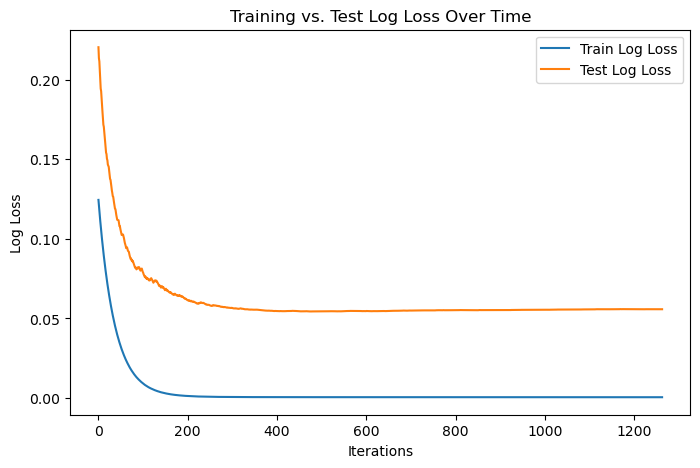

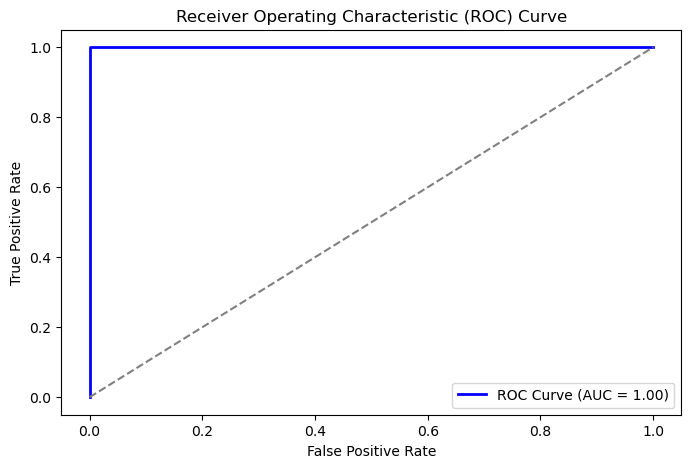

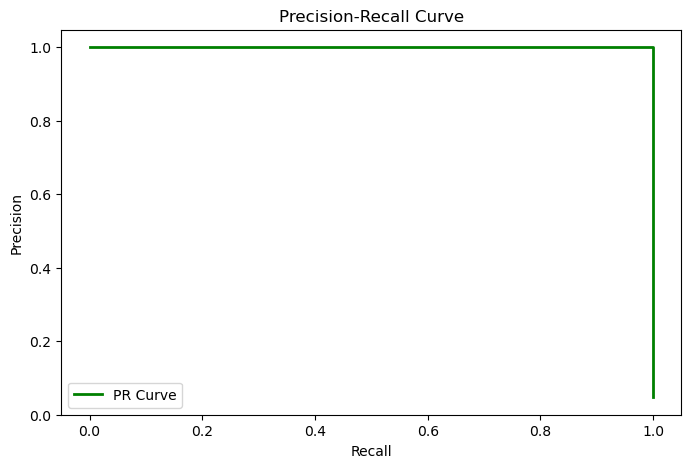

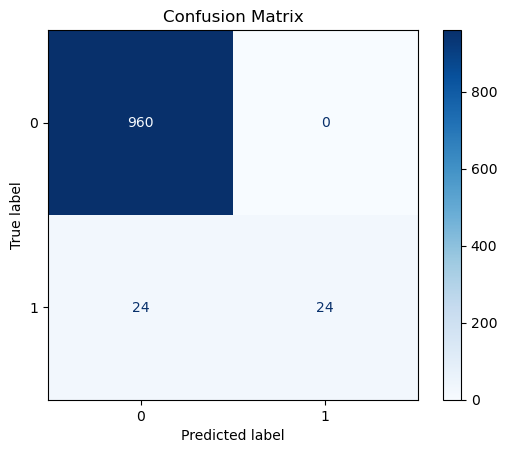

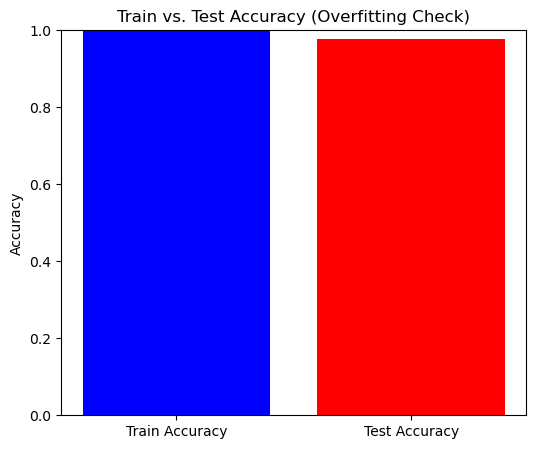

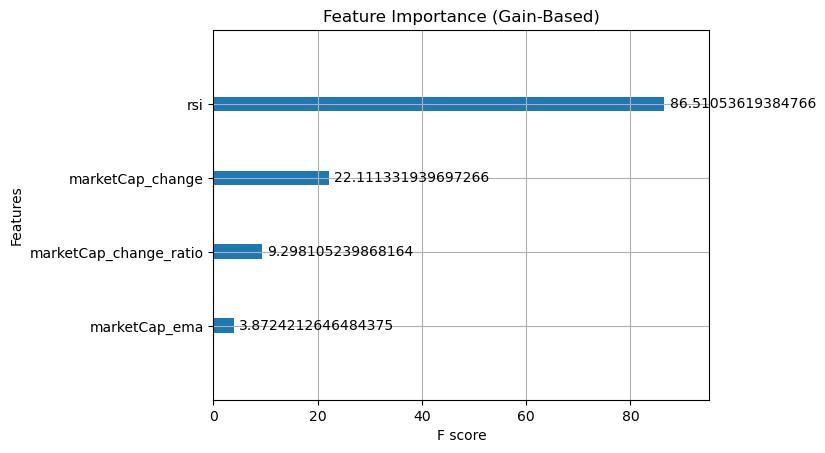

In [58]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

results = final_model.evals_result()
epochs = len(results["validation_0"]["logloss"])

plt.figure(figsize=(8,5))
plt.plot(range(epochs), results["validation_0"]["logloss"], label="Train Log Loss")
plt.plot(range(epochs), results["validation_1"]["logloss"], label="Test Log Loss")
plt.xlabel("Iterations")
plt.ylabel("Log Loss")
plt.title("Training vs. Test Log Loss Over Time")
plt.legend()
plt.show()

#ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)

plt.figure(figsize=(8,5))
plt.plot(recall, precision, color="green", lw=2, label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Train vs Test Accuracy (Overfitting Check)
train_acc = final_model.score(X_train, y_train)
test_acc = final_model.score(X_test, y_test)

plt.figure(figsize=(6,5))
plt.bar(["Train Accuracy", "Test Accuracy"], [train_acc, test_acc], color=["blue", "red"])
plt.ylabel("Accuracy")
plt.title("Train vs. Test Accuracy (Overfitting Check)")
plt.ylim(0, 1)
plt.show()

# Feature Importance (Gain-based)
xgb.plot_importance(final_model, importance_type='gain', title="Feature Importance (Gain-Based)")
plt.show()